# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.308775,False,-0.317385
1,0.329359,False,1.000021
2,1.592320,False,2.687260
3,0.355527,True,6.047844
4,-0.395587,False,-0.536472
...,...,...,...
995,0.727129,True,4.164100
996,0.839767,True,4.189129
997,-0.054836,False,0.076386
998,0.384084,True,6.915152


<Axes: xlabel='v0'>

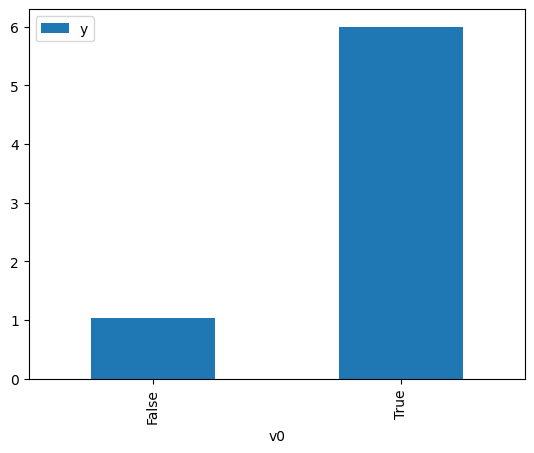

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

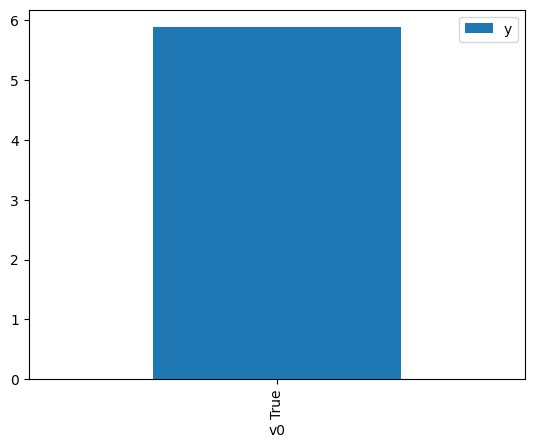

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.743396,False,2.464858,0.230851,4.331795
1,1.677032,False,2.585395,0.238648,4.190274
2,1.685385,False,2.685880,0.237657,4.207751
3,1.167124,False,1.070008,0.304363,3.285552
4,0.266635,False,-1.397632,0.440864,2.268271
...,...,...,...,...,...
995,0.245172,False,0.334795,0.444328,2.250592
996,0.936735,False,-0.166433,0.337171,2.965851
997,1.167124,False,1.070008,0.304363,3.285552
998,0.872544,False,2.697726,0.346617,2.885026


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.836126,True,7.173894,0.779741,1.282477
1,1.854739,True,7.279853,0.781825,1.279059
2,2.466491,True,8.438103,0.842433,1.187038
3,-0.153800,True,5.445220,0.490670,2.038031
4,1.579504,True,6.544560,0.749570,1.334098
...,...,...,...,...,...
995,1.209058,True,6.242535,0.701413,1.425694
996,0.922132,True,7.264413,0.660691,1.513567
997,0.179607,True,3.760599,0.545061,1.834656
998,1.934576,True,6.447690,0.790601,1.264861


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          1.406e+04
Date:                Wed, 22 May 2024   Prob (F-statistic):                        0.00
Time:                        18:55:00   Log-Likelihood:                         -1392.6
No. Observations:                1000   AIC:                                      2789.
Df Residuals:                     998   BIC:                                      2799.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2220      0.030     40.708      0.000       1.163       1.281
x2             4.9084      0.051     96.356      0.000       4.808       5.008
==============================================================================
Omnibus:                        0.274   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.872   Jarque-Bera (JB):                0.262
Skew:                           0.040   Prob(JB):                        0.877
Kurtosis:                       2.997   Cond. No.                         2.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""